# Item-based Collaborative Filtering on the 1M MovieLens Dataset
###  Individual Assignment <br> Pip Velthuijs, 500831930


This MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.
 
Source: <br>
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

In [1]:
#importing libraries
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from math import sqrt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

# EDA 

In [2]:
# reading the dataset and showing it
df_data = pd.read_csv(r"C:\Users\pipve\OneDrive\Documenten\Master\System development\ml-1m\ml-1m\ratings.dat", sep='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

df_data.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


The "ratings.dat" has 4 columns: <br>

UserId - Every user is represented by an unique Id. <br>
MovieID - Every movie is represented by an uniue Id. <br>
Rating - Represents the rating given by the user to the corresponding item (movie).<br>
Timestamp - The time at which the rating was recorded.<br>

In [3]:
# looking at the description of the dataset
df_data.describe()

,UserID,MovieID,Rating,Timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


The dataset contains 1,000,209 entries.

User-Item Interaction:
Users range from 1 to 6,040, and items range from 1 to 3,952. They have (on average) rated around 3,024 items, and the items have received ratings from approximately 1,865 users. The majority of ratings fall between 3 and 4, as indicated by the quartiles.

Ratings:
Ratings have a mean of approximately 3.58, with a minimum of 1 and a maximum of 5. The standard deviation is around 1.12, indicating diverse opinions in the dataset.

Timestamp:
The timestamp suggests that the ratings span a period, starting from around 956.7 million seconds to 1,046.5 million seconds. The standard deviation of 12.2 million seconds suggests that the user-item interactions are spread across time rather than being concentrated around a specific period.

In conclusion, the dataset represents user-item interactions with ratings, spanning a diverse set of items and users over a period. The ratings are on a scale of 1 to 5, with most falling between 3 and 4, suggesting a generally positive sentiment.

In [4]:
# to be sure, checking if there are NaN values in the dataset
nan_values = df_data.isna().sum()
print(nan_values)

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64


There are no NaN values in the dataset. That's good.

In [5]:
#loading & showing the next dataset
df_movies = pd.read_csv(r"C:\Users\pipve\OneDrive\Documenten\Master\System development\ml-1m\ml-1m\movies.dat", delimiter='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin1')
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Split the 'Genres' column into separate binary columns
genres = df_movies['Genres'].str.get_dummies(sep='|')

# Concatenate the one-hot encoded genres with the original DataFrame
df_item = pd.concat([df_movies, genres], axis=1)

# Drop the original 'Genres' column
df_item.drop(columns=['Genres'], inplace=True)

# Display the resulting item df
df_item.head()

,MovieID,Title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
#looking at the description of the item dataset
df_item.describe()

,MovieID,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,1986.049446,0.129539,0.072882,0.027041,0.064641,0.309039,0.054339,0.032707,0.412825,0.017512,0.011331,0.088334,0.029359,0.027298,0.121298,0.071079,0.126706,0.036827,0.017512
std,1146.778349,0.335839,0.259976,0.162224,0.245923,0.462157,0.226715,0.177891,0.492405,0.131187,0.105858,0.283816,0.168832,0.162973,0.326515,0.256990,0.332686,0.188362,0.131187
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,982.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2980.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3952.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Explanation of the item data:

The dataset contains information about 3,883 movies. Each movie is identified by a unique 'MovieID' ranging from 1 to 3,952.

The mean values for each genre represent the average occurrence of that genre across all movies. Genres like 'Comedy' and 'Drama' have relatively high mean values around 0.31 and 0.41, suggesting they are commonly assigned to movies. Conversely, genres like 'Animation' and 'Fantasy' have lower mean values, indicating they are less frequently assigned.

The standard deviation values measure the variability or spread of genre occurrences across movies. For example, Comedy and Drama have higher standard deviations compared to genres like Animation and Fantasy, indicating more variation in assigning these genres.

The 25th, 50th, and 75th percentiles provide insights into the distribution of genre occurrences. For example, the 75th percentile value for 'Comedy' is 1, suggesting that 75% of movies have at least one 'Comedy' genre assigned to them.

In [8]:
# checking if there are NaN values in the dataset
nan_values = df_item.isna().sum()
print(nan_values)

MovieID        0
Title          0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64


There are no NaN values in the item data, so that is good.

In [9]:
# loading and showing the last users dataset
df_users = pd.read_csv(r"C:\Users\pipve\OneDrive\Documenten\Master\System development\ml-1m\ml-1m\users.dat", delimiter='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


The occupations are now only numbers. Also the age groups are not defined yet. Let's fix that.

In [10]:
# Define a dictionary mapping occupation codes to occupation names
occupation_mapping = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

# Mapping the occupation column using the occupation_mapping dictionary
df_users['Occupation'] = df_users['Occupation'].map(occupation_mapping)

# Defining a dictionary mapping original age values to the desired format
age_mapping = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+"
}

# Mapping the Age column using the age_mapping dictionary
df_users['Age'] = df_users['Age'].map(age_mapping)

# showing the modified df
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,K-12 student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


Now the age groups are defined as well as the occupations.

In [11]:
# checking if there are NaN values in the dataset
nan_values = df_users.isna().sum()
print(nan_values)

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64


There are no NaN values, which is good.

Now I want to merge the three datasets into 1, so I can use that merged dataset also in other analysis. It seems that 'UserID' is a common column between df_data and df_users, and 'MovieID' is a common column between df_data and df_item. As a result, I will use these columns to perform the merge.

In [12]:
# Merge df_data with df_users on UserID
merged_data_users = pd.merge(df_data, df_users, on='UserID')

# Merging the result with df_item on MovieID
final_merged_df = pd.merge(merged_data_users, df_item, on='MovieID')

# Printing the first few rows of the merged dataset to see if it is correct
final_merged_df.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,978300760,F,Under 18,K-12 student,48067,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0
1,2,1193,5,978298413,M,56+,self-employed,70072,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0
2,12,1193,4,978220179,M,25-34,programmer,32793,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0
3,15,1193,4,978199279,M,25-34,executive/managerial,22903,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0
4,17,1193,5,978158471,M,50-55,academic/educator,95350,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0


It seems that the merge worked, however to be sure I want to see some more details since this df.head() only shows the first 5 rows. 

In [13]:
#using df.describe() to check if the merge is done right and to describe the dataset
final_merged_df.describe()

,UserID,MovieID,Rating,Timestamp,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,...,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08,2.574032e-01,1.339250e-01,4.328395e-02,7.217092e-02,3.565055e-01,7.952438e-02,...,3.629341e-02,1.825718e-02,7.637004e-02,4.152432e-02,4.016960e-02,1.474922e-01,1.572611e-01,1.896404e-01,6.851268e-02,2.067868e-02
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07,4.372036e-01,3.405719e-01,2.034957e-01,2.587708e-01,4.789672e-01,2.705556e-01,...,1.870194e-01,1.338801e-01,2.655894e-01,1.994996e-01,1.963569e-01,3.545960e-01,3.640470e-01,3.920166e-01,2.526237e-01,1.423063e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


The merge of the datasets is succesfull, since the dataset contains 1,000,209 records, with UserID ranging from 1 to 6040 and MovieID ranging from 1 to 3952

In [14]:
# To be sure I am checking for duplicates with an if else statement
duplicates = final_merged_df[final_merged_df.duplicated()]

if not duplicates.empty: # suggesting that if there are duplicates it should print the following
    print("Amount of duplicates found:") 
    print(duplicates)
else:
    print("There are no duplicates in the dataset") # if they are no duplicates, then it should print the following

There are no duplicates in the dataset


The dataset is correct without duplicates. Now I will do some more EDA to explore. 

# About the users

### Gender

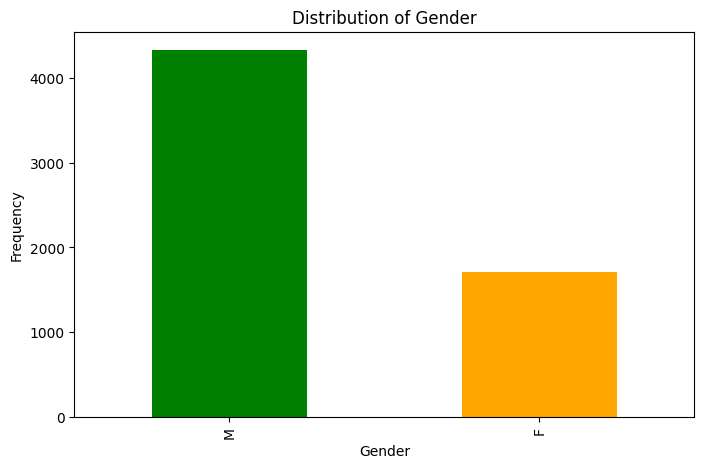

In [15]:
# making a plot for gender distribution
plt.figure(figsize=(8, 5)) #setting size of the plot
# grouping on UserID so the onces who rated more movies arent included multiple times. Also assigning colors to Male and Female
final_merged_df.groupby('UserID')['Gender'].first().value_counts().plot(kind='bar', color=['green', 'orange'])
plt.title('Distribution of Gender') # adding a title
plt.xlabel('Gender') # adding the x-axis label
plt.ylabel('Frequency') # adding the y-axis label
plt.show() # showing the plot


As shown in the figure, there is an imbalance in gender, since there are a lot more men than women. 

### Age

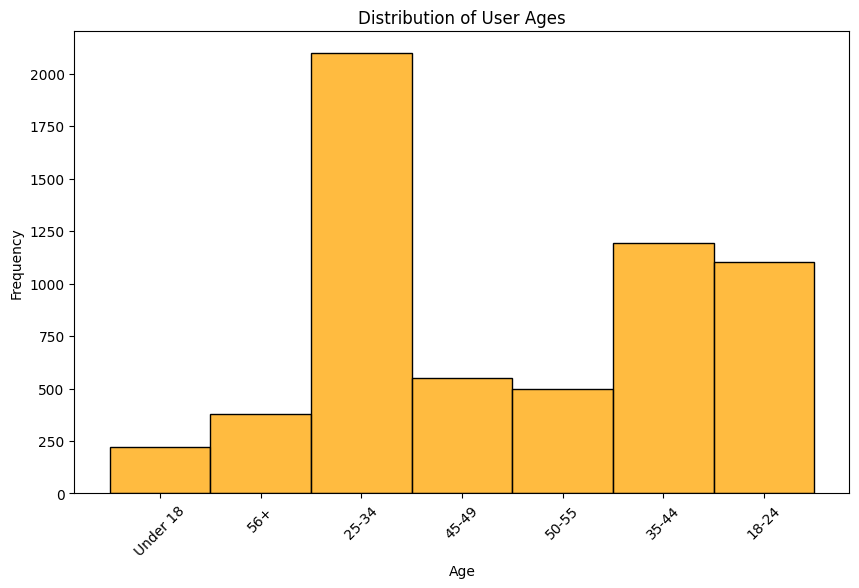

In [16]:
# Setting the figure size
plt.figure(figsize=(10, 6))
sns.histplot(data=df_users, x='Age', color='orange', edgecolor='black', discrete=True) # Creating a histogram plot for the age column
plt.title('Distribution of User Ages') #adding a title
plt.xlabel('Age') #adding x-axis label
plt.ylabel('Frequency') #adding Y-axis label
plt.xticks(rotation=45) # Rotating x-axis labels for better readability
plt.show() # Showing the plot

The plot shows there are a lot of young people who are 25-34 years old. The least amount is under 18.

### Profession

C:\Users\pipve\AppData\Local\Temp\ipykernel_10936\2948774676.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=user_occupation_counts, palette='pastel') # creating a plot and assigning colors


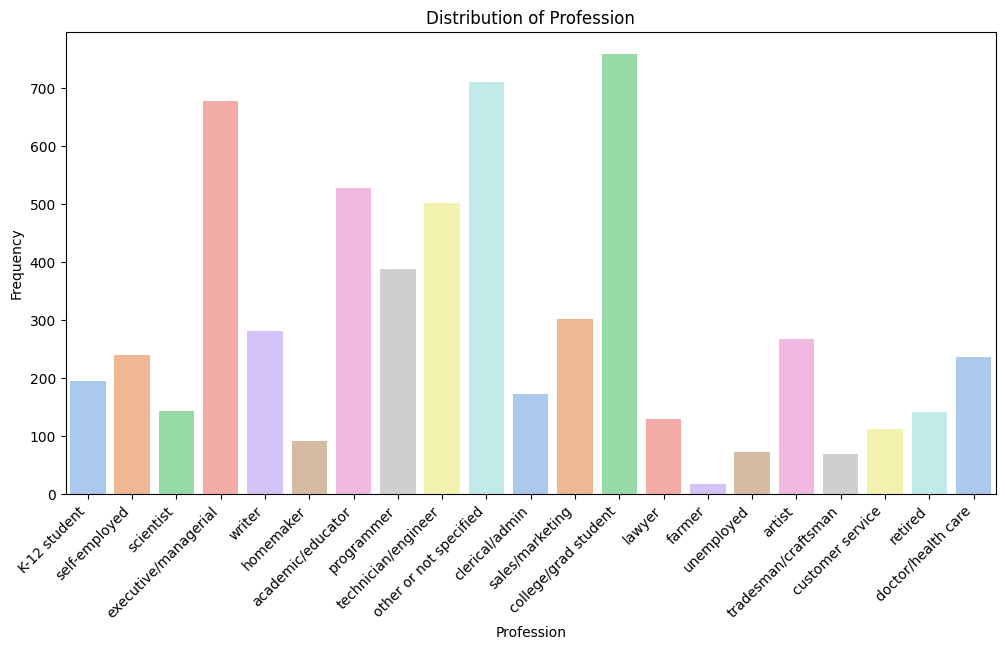

In [17]:
plt.figure(figsize=(12, 6)) #setting the figure size
user_occupation_counts = final_merged_df.groupby('UserID')['Occupation'].first() # Grouping on UserID so there won't be double counting of users
sns.countplot(x=user_occupation_counts, palette='pastel') # creating a plot and assigning colors
plt.title('Distribution of Profession') # creating a title
plt.xlabel('Profession') # creating x-axis label
plt.ylabel('Frequency') # creating y-axis label
plt.xticks(rotation=45, ha='right') #rotating x-axis labels for better readability
plt.show() #showing plot

The dataset mostly consists of college/grad students, with over 700 counts. Other common professions include 'other', 'executive/managerial', 'academic/educator', 'technician/engineer' ,and 'programmers'. On the flip side, 'farmer' and 'unemployed' are the least represented in the dataset.


# About the Movies

C:\Users\pipve\AppData\Local\Temp\ipykernel_10936\3822616065.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genres_count.values, y=genres_count.index, palette='pastel') # making barplot and setting color


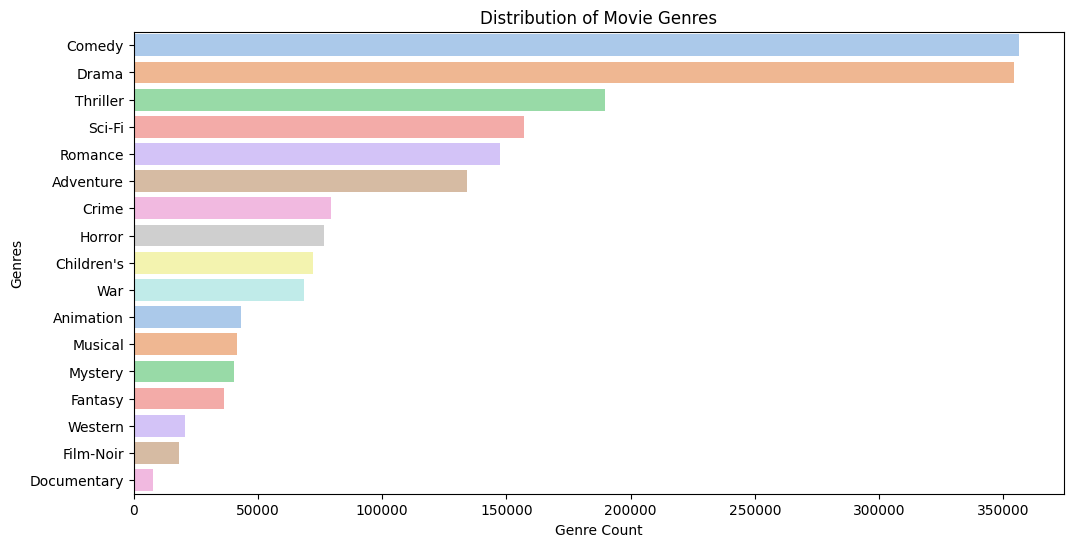

In [18]:
plt.figure(figsize=(12, 6)) # setting figure size
genres_count = final_merged_df.iloc[:, 10:].sum().sort_values(ascending=False) # selecting genre columns and summing
sns.barplot(x=genres_count.values, y=genres_count.index, palette='pastel') # making barplot and setting color
plt.title('Distribution of Movie Genres') # giving the figure a title
plt.xlabel('Genre Count') # labelling x-axis
plt.ylabel('Genres') # labelling y-axis
plt.show() # showing the distribution of genres

As shown in this plot, the genre comedy is counted most, followed by drama, thriller, sci-fi and romance. The least counted genres are documentary, film noir and western. 

## About the ratings

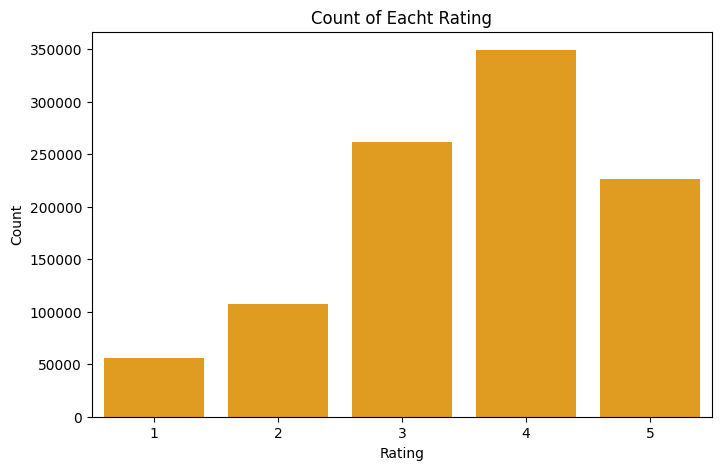

The amount per Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64


In [19]:
# making a plot for showing the count occurrences of each rating
rating_counts = final_merged_df['Rating'].value_counts().sort_index()
plt.figure(figsize=(8, 5)) # setting the figure size
sns.barplot(x=rating_counts.index, y=rating_counts.values, color='orange') # making a barplot and setting the color to orange
plt.title('Count of Eacht Rating') # giving title to the plot
plt.xlabel('Rating') # giving x-axis a label
plt.ylabel('Count') # giving the y-axis a label
plt.show()# showing the plot

print('The amount per',rating_counts)

As shown in the plot as well as in the numbers, most people gave out good ratings, whereas 4 is given out most (by 348971 users), followed by 3, 5, 2 and 1. 

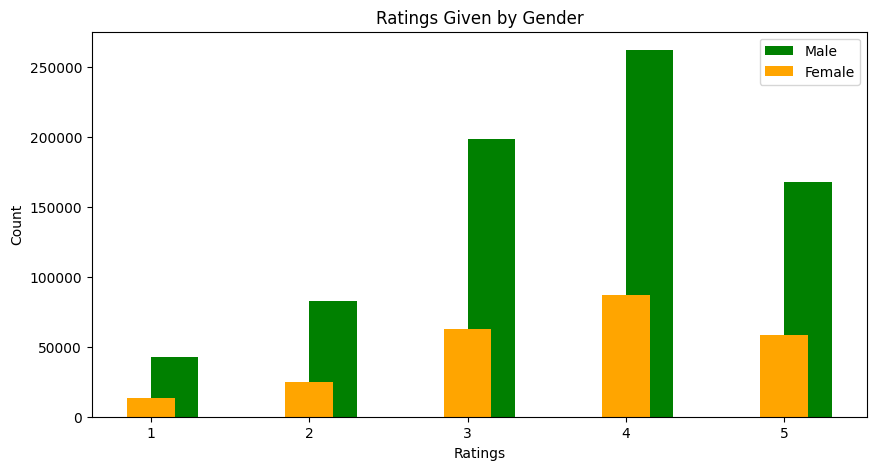

In [20]:
# Grouping by gender and rating and calculating the count of each combination
temp_df = final_merged_df.groupby(['Gender', 'Rating']).size()

plt.figure(figsize=(10, 5)) # Setting the plot size

# Sorting the values for male and female genders
m_temp_df = temp_df['M'].sort_index(ascending=False)
f_temp_df = temp_df['F'].sort_index(ascending=False)

# Creating bar plots for male and female ratings and adding colors
plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Male", align="edge", width=0.3, color='green')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Female", width=0.3, color='orange')

plt.title('Ratings Given by Gender') # Setting the title of the plot
plt.legend() #Adding legend
plt.xlabel('Ratings') # Setting the label for the x-axis
plt.ylabel('Count') # Setting the label for the y-axis
plt.show() # Showing the plot


The plot shows that both male and female viewers tend to give higher ratings, with peaks around 4, 3, and 5. Additionally, male viewers appear to give more ratings. This is probably because of the imbalance as discussed before. 

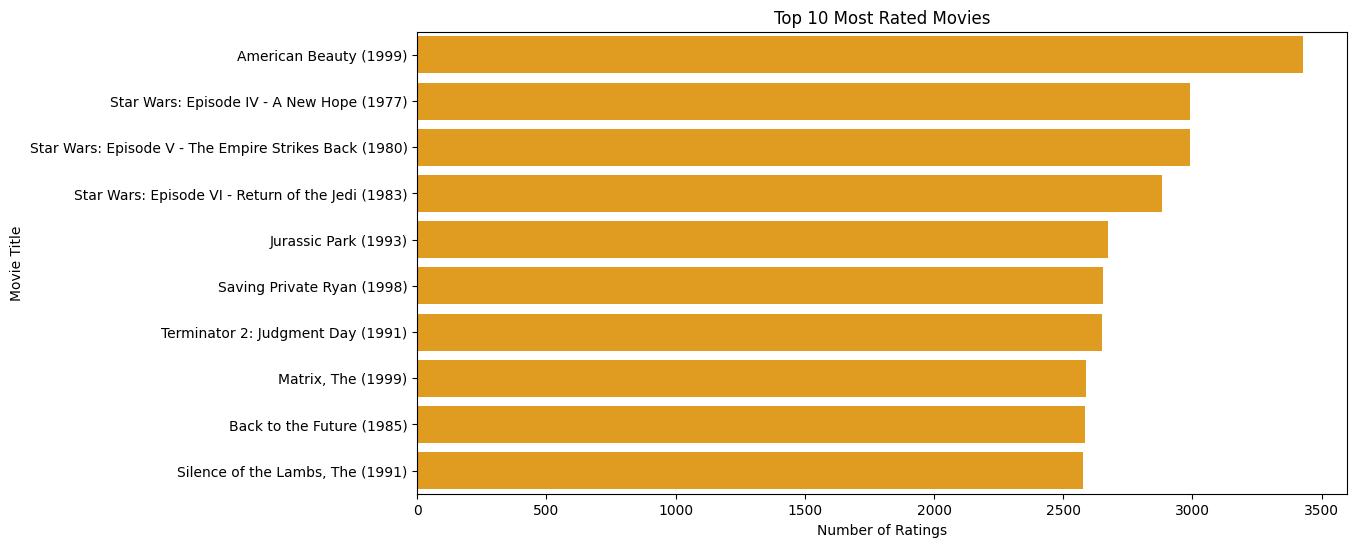

In [21]:
# making a plot of the movies that had the most ratings  
number_of_ratings = final_merged_df['Title'].value_counts() #calculating the number of ratings for each movie
top_rated_movies = number_of_ratings.head(10) # Selecting the top 10 movies


plt.figure(figsize=(12, 6)) # setting the figure size of the plot
sns.barplot(x=top_rated_movies.values, y=top_rated_movies.index, color='orange') # making barplot and setting color
plt.title('Top 10 Most Rated Movies') # adding a title to the plot
plt.xlabel('Number of Ratings') # labelling x-axis
plt.ylabel('Movie Title') # labelling y-axis
plt.show() # showing the plot

As shown in the plot, American Beauty received the most ratings, followed by Star wars IV, V, VI, and Jurassic Park

In [22]:
# Grouping by title and calculating the mean rating and count for each movie
avg_highly_rated_movies = final_merged_df.groupby(['Title']).agg({"Rating":["mean", "count"]})

# Flatten the multi-index columns
avg_highly_rated_movies.columns = avg_highly_rated_movies.columns.map('_'.join)

# Sorting by average rating in descending order
avg_highly_rated_movies = avg_highly_rated_movies.sort_values(by='Rating_mean', ascending=False)

# Showing the top 20 movies with the highest average ratings along with their counts
avg_highly_rated_movies.head(20)


,Rating_mean,Rating_count
Title,,
Ulysses (Ulisse) (1954),5.000000,1
Lured (1947),5.000000,1
Follow the Bitch (1998),5.000000,1
Bittersweet Motel (2000),5.000000,1
Song of Freedom (1936),5.000000,1
One Little Indian (1973),5.000000,1
Smashing Time (1967),5.000000,2
Schlafes Bruder (Brother of Sleep) (1995),5.000000,1
"Gate of Heavenly Peace, The (1995)",5.000000,3


There are 10 movies with very high average ratings of 5.0. However, since only 1 or sometimes 2 or 3 people rated them, these ratings are not very accurate. It is therefore good to look into the distribution of amount of ratings given by a user as well as received by a movie. 

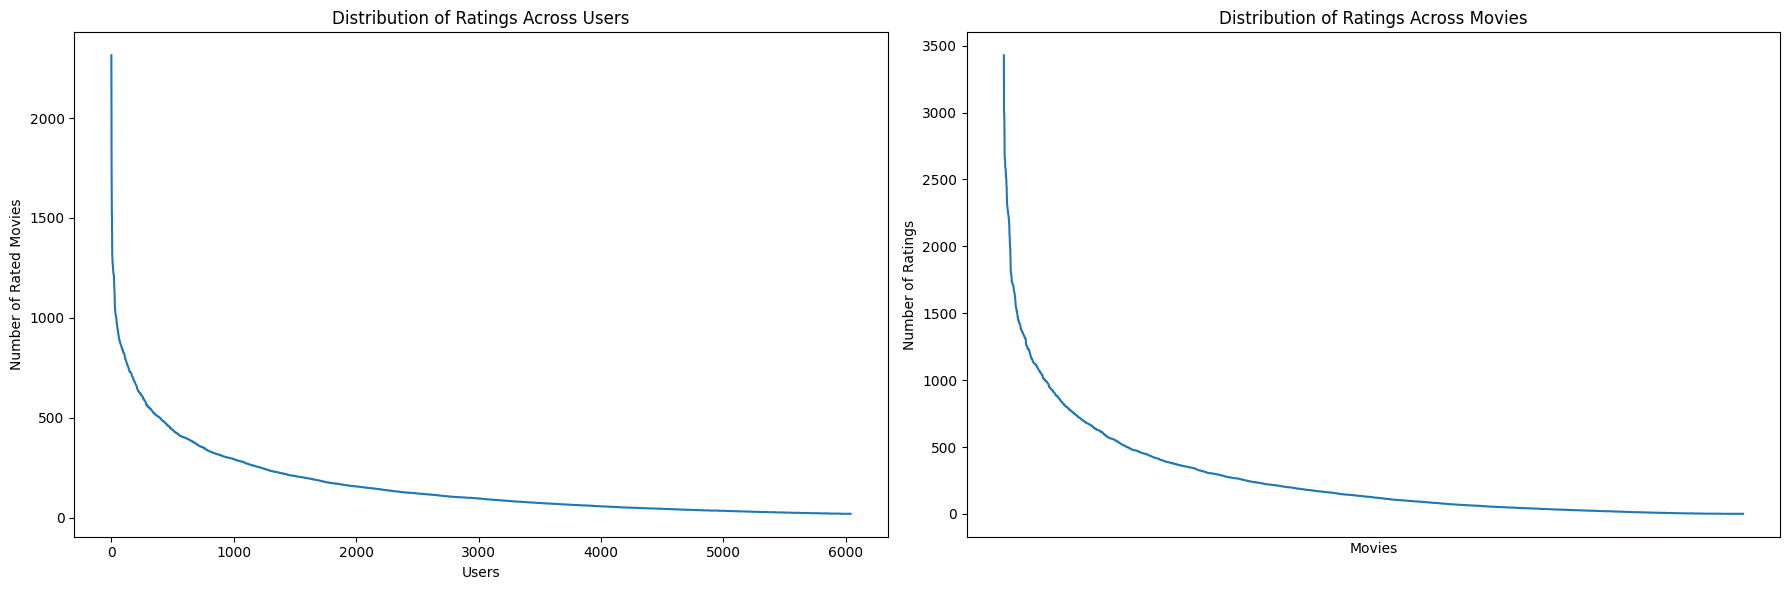

In [23]:
# Creating subplots to check the distribution of ratings per movies and per users
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plotting distribution of ratings across users
number_of_ratings_per_user = final_merged_df['UserID'].value_counts()
number_of_ratings_per_user_sorted = number_of_ratings_per_user.sort_values(ascending=False)
sns.lineplot(data=number_of_ratings_per_user_sorted.values, ax=axes[0])
axes[0].set_title('Distribution of Ratings Across Users')
axes[0].set_xlabel('Users')
axes[0].set_ylabel('Number of Rated Movies')

# Plotting distribution of ratings across all movies
number_of_ratings = final_merged_df['Title'].value_counts()
sns.lineplot(data=number_of_ratings, ax=axes[1])
axes[1].set_title('Distribution of Ratings Across Movies')
axes[1].set_xlabel('Movies')
axes[1].set_ylabel('Number of Ratings')
axes[1].set_xticks([])  #Removing movie names from the x-axis, because there are way too many to show

plt.tight_layout()
plt.show()

Distribution of ratings across users: <br> 
The plot shows a long-tail distribution, where a few users have rated a large number of movies, while the majority of users have rated a smaller number of movies. This suggests that there are some highly active users who contribute significantly to the overall ratings dataset. Also the plot shows there is no count of 0.

Distribution of ratings across all movies: <br>
This plot also shows a long-tail distribution, indicating that a few movies have received a large number of ratings, while the majority of movies have received fewer ratings. This suggests that there are popular movies that attract a lot of attention and ratings, while many other movies receive relatively fewer ratings. In this plot there seems to be movies which have received 0 ratings.

<br>
As a result, I will take a closer look at the minimal count of ratings per users and movies

In [24]:
# Counting the number of ratings for each user
number_of_ratings_per_user = final_merged_df['UserID'].value_counts()

# Finding the minimum number of movies rated per user and printing them
min_movies_rated_per_user = number_of_ratings_per_user.min()

print("Minimum number of movies rated per user:", min_movies_rated_per_user)

# Counting the number of ratings for each movie
number_of_ratings_per_movie = final_merged_df['Title'].value_counts()

# Finding the minimum number of ratings received by a movie and priting the outcome
min_ratings_per_movie = number_of_ratings_per_movie.min()

print("Minimum number of ratings received by a movie:", min_ratings_per_movie)

Minimum number of movies rated per user: 20
Minimum number of ratings received by a movie: 1


The minimum number of movies rated per user is 20, so there are no users who have rated fewer than 20 movies. This can be improves by putting the treshold on 50 so there will be more accuracy.  <br>

The minimum number of ratings received by a movie is 1. This means that there are movies in the dataset that have received only a single rating. Based on only 1 rating it is very hard to recommend things. Also, movies with very few ratings may not accurately reflect their true quality or popularity. Excluding these movies can help improve the overall quality of the recommendations by focusing on more reliable data. As a result i will print out different tresholds for of a minimum of 50 ratings per movie, so that I do exclude some, but not too many, since the dataset is not that big.

In [25]:
# Filtering movies with fewer than 50 ratings
movies_to_exclude = number_of_ratings_per_movie[number_of_ratings_per_movie < 50].index

# Filtering in df to exclude movies with fewer than 50 ratings
filtered_df = final_merged_df[~final_merged_df['MovieID'].isin(movies_to_exclude)]

# showing the shape of the filtered df to verify the shape
print("The dataframe after excluding movies with fewer than 50 ratings:", filtered_df.shape)


The dataframe after excluding movies with fewer than 50 ratings: (1000209, 27)


Now I do the same thing for number of ratings received by movies. Let's find a good treshold first.

In [26]:
# Calculating the average number of ratings received by each movie
average_ratings_per_movie = number_of_ratings_per_movie.mean()

print("Average number of ratings received by each movie:", average_ratings_per_movie)

# Calculating the minimum number of ratings received by a movie
min_ratings_per_movie = number_of_ratings_per_movie.min()

print("Minimum number of ratings received by a movie:", min_ratings_per_movie)

# Calculating the maximum number of ratings received by a movie
max_ratings_per_movie = number_of_ratings_per_movie.max()

print("Maximum number of ratings received by a movie:", max_ratings_per_movie)

Average number of ratings received by each movie: 269.88909875876953
Minimum number of ratings received by a movie: 1
Maximum number of ratings received by a movie: 3428


In [27]:
# Filter movies with fewer than 5 ratings
movies_under_20_ratings = number_of_ratings[number_of_ratings < 21]
movies_under_50_ratings = number_of_ratings[number_of_ratings < 51]
movies_under_100_ratings = number_of_ratings[number_of_ratings < 101]

num_movies_under_20_ratings = len(movies_under_20_ratings)
print("Number of movies with fewer than 20 ratings:", num_movies_under_20_ratings)

num_movies_under_50_ratings = len(movies_under_50_ratings)
print("Number of movies with fewer than 50 ratings:", num_movies_under_50_ratings)

num_movies_under_100_ratings = len(movies_under_100_ratings)
print("Number of movies with fewer than 100 ratings:", num_movies_under_100_ratings)

Number of movies with fewer than 20 ratings: 695
Number of movies with fewer than 50 ratings: 1207
Number of movies with fewer than 100 ratings: 1700


I will put a treshold for minimum of 100 ratings per movie to improve my recommendations.

In [28]:
# Filter movies with fewer than 50 ratings
movies_to_exclude = number_of_ratings[number_of_ratings < 101].index

# Filter the final_merged_df DataFrame to exclude movies with fewer than 50 ratings
filtered_df = final_merged_df[~final_merged_df['Title'].isin(movies_to_exclude)]

# Display the shape of the filtered DataFrame to verify the exclusion
print("The dataframe after excluding movies with fewer than 100 ratings:", filtered_df.shape)

The dataframe after excluding movies with fewer than 100 ratings: (940925, 27)


After excluding movies with fewer than 100 ratings from the dataset, the resulting dataframe contains 977089 entries and 27 columns. This exclusion helps ensure that my analysis focuses on movies that have received a more substantial number of ratings, potentially leading to more reliable insights and recommendations.

In [29]:
filtered_df.head() #showing the filtered df

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,978300760,F,Under 18,K-12 student,48067,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0
1,2,1193,5,978298413,M,56+,self-employed,70072,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0
2,12,1193,4,978220179,M,25-34,programmer,32793,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0
3,15,1193,4,978199279,M,25-34,executive/managerial,22903,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0
4,17,1193,5,978158471,M,50-55,academic/educator,95350,One Flew Over the Cuckoo's Nest (1975),0,...,0,0,0,0,0,0,0,0,0,0


I see that I still need to perform one-hot-encoding for gender, age and occupation so i can use that in other analysis (SVD) too. Also I will drop the timestamp and zipcodes because Iam not going to use them.

In [30]:
# Encoding categorical features (Gender, Age, Occupation)
df_encoded = pd.get_dummies(filtered_df, columns=['Gender', 'Age', 'Occupation'])

#Drop columns timestamp and zip-code
filtered_df= df_encoded.drop(['Timestamp', 'Zip-code'], axis=1)

# showing the updated df
filtered_df

,UserID,MovieID,Rating,Title,Action,Adventure,Animation,Children's,Comedy,Crime,...,Occupation_other or not specified,Occupation_programmer,Occupation_retired,Occupation_sales/marketing,Occupation_scientist,Occupation_self-employed,Occupation_technician/engineer,Occupation_tradesman/craftsman,Occupation_unemployed,Occupation_writer
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,False
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991639,5841,3445,3,Eyes of Laura Mars (1978),0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
991640,5852,3445,2,Eyes of Laura Mars (1978),0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
991641,5916,3445,3,Eyes of Laura Mars (1978),0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
991642,5954,3445,3,Eyes of Laura Mars (1978),0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


It's all done correct. Now I will save this df to parquet so it can easily be retrieved in other analyses too. 

In [31]:
# Specify the file path where you want to save the Parquet file
file_path = r"C:\Users\pipve\OneDrive\Documenten\Master\System development\ml-1m\filtered_df.parquet"

# Save the DataFrame to Parquet format
filtered_df.to_parquet(file_path)

print("DataFrame saved to Parquet successfully.")

DataFrame saved to Parquet successfully.


## Collaborative filtering item knn

*Stratified sampling and train, test, validation set*

In the following section of the code, I aim to perform stratified sampling based on MovieID. Also, a sample size of 500,000 is chosen in order to let it run faster. The dataset is grouped by MovieID, and within each group, a sample of the data is taken, ensuring that each MovieID category is represented proportionally in the sampled data. This helps to maintain the integrity of the original distribution of MovieID categories while reducing the dataset size for computational efficiency and ensuring a representative sample. 
After performing stratified sampling, the dataset is split into three subsets: train, test, and validation sets. The train set is used for training the model, the test set for evaluating its performance, and the validation set for tuning hyperparameters and preventing overfitting. Furthermore, I ensure that the distribution of ratings across these subsets remains similar to that of the original dataset. Additionally, I check if the MovieID values are aligned across the subsets to maintain consistency in the dataset split.

In [32]:
sample_size = 50000 #setting the sample size to 50000

# Performing stratified sampling based on MovieID
stratified_sampled_data = filtered_df.groupby('MovieID', group_keys=False, as_index=False).apply(lambda x: x.sample(min(len(x), sample_size))) 


# Splitting the stratified sampled data into train, test, and validation sets
train, remaining = train_test_split(stratified_sampled_data, test_size=0.2, stratify=stratified_sampled_data['MovieID'], random_state=42)
test, validation = train_test_split(remaining, test_size=0.5, stratify=remaining['MovieID'], random_state=42)

# ensuring similar distribution of ratings in train, test, and validation sets 
rating_distribution = filtered_df['Rating'].value_counts(normalize=True)
train_distribution = train['Rating'].value_counts(normalize=True)
test_distribution = test['Rating'].value_counts(normalize=True)
validation_distribution = validation['Rating'].value_counts(normalize=True)

#printing the distribution of the original, train, test and validation set in order to check if it is done correct
print("Original Rating Distribution:")
print(rating_distribution)
print("\nTrain Rating Distribution:")
print(train_distribution)
print("\nTest Rating Distribution:")
print(test_distribution)
print("\nValidation Rating Distribution:")
print(validation_distribution)

# Checking if MovieID values are aligned across train, test, and validation sets and also printing this
train_movie_ids = train['MovieID'].unique()
test_movie_ids = test['MovieID'].unique()
validation_movie_ids = validation['MovieID'].unique()

if set(train_movie_ids) == set(test_movie_ids) == set(validation_movie_ids):
    print("MovieID values are aligned across train, test, and validation sets.")
else:
    print("Warning: MovieID values are not aligned across train, test, and validation sets.")

Original Rating Distribution:
Rating
4    0.352981
3    0.259070
5    0.232688
2    0.103836
1    0.051425
Name: proportion, dtype: float64

Train Rating Distribution:
Rating
4    0.353295
3    0.258967
5    0.232641
2    0.103781
1    0.051317
Name: proportion, dtype: float64

Test Rating Distribution:
Rating
4    0.351932
3    0.258874
5    0.233697
2    0.104143
1    0.051354
Name: proportion, dtype: float64

Validation Rating Distribution:
Rating
4    0.351525
3    0.260083
5    0.232058
2    0.103972
1    0.052363
Name: proportion, dtype: float64
MovieID values are aligned across train, test, and validation sets.


As the print statements shows, the MovieID values are aligned in the sets. That's great.

#### Creating User-Item Matrix 

In [33]:
# Create user-item matrices for train, test, and validation sets
train_matrix = train.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
test_matrix = test.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
validation_matrix = validation.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

train_matrix

MovieID,1,2,3,4,5,6,7,9,10,11,...,3927,3928,3929,3930,3932,3936,3937,3948,3949,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now I want to ensure that all three matrices (train, validation, and test) have the same rows (userIDs) with any missing values filled with 0. This facilitates consistency and compatibility which is usefull for within my model.

In [34]:
# Getting a union of all userIDs from the training, validation, and test sets
all_users = set(train_matrix.index) | set(validation_matrix.index) | set(test_matrix.index)

# Reindex the matrices to ensure they all have the same rows (filling missing values with 0)
train_matrix = train_matrix.reindex(index=all_users, fill_value=0)
validation_matrix = validation_matrix.reindex(index=all_users, fill_value=0)
test_matrix = test_matrix.reindex(index=all_users, fill_value=0)

For item-knn I need a transpose of the matrix in order to get an item-item matrix. Let's do that:

In [35]:
# Transpose user-item matrices to item-user matrices using transpose
train_item_item_matrix = train_matrix.T
test_item_item_matrix = test_matrix.T
validation_item_item_matrix = validation_matrix.T

# Now i have item-user matrices for train, test, and validation sets. Let's print it to check
print("Train item-item matrix:")
print(train_item_item_matrix)

Train item-item matrix:
UserID   1     2     3     4     5     6     7     8     9     10    ...  \
MovieID                                                              ...   
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   4.0   5.0   5.0  ...   
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3936      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3937      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3948      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   4.0  ...   
3949      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3952      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

In [36]:
print(train_item_item_matrix.shape)
print(test_item_item_matrix.shape)
print(validation_item_item_matrix.shape)

(2006, 6040)
(2006, 6040)
(2006, 6040)


It seems the item-item matrices are created correct.

### Creating Cosine, Manhattan and Pearson matrices

I will compute three essential matrices: the cosine similarity matrix, Manhattan distance matrix, and Pearson correlation coefficient matrix, based on an item-item interaction matrix. The cosine similarity matrix measures similarity in directionality between items, the Manhattan distance matrix quantifies the absolute differences in interactions, and the Pearson correlation coefficient matrix evaluates the linear correlation between items' interactions. These matrices I later on use to give personalized recommendations for users, since they are based on item similarities.

In [37]:
# Computing cosine similarity matrix
cosine_similarity_matrix = cosine_similarity(train_item_item_matrix)

# Computing Manhattan distance matrix
manhattan_distance_matrix = squareform(pdist(train_item_item_matrix, 'cityblock'))

# Computing Pearson correlation coefficient matrix
pearson_correlation_matrix = np.corrcoef(train_item_item_matrix)

#printing the matrices
print("Cosine Similarity Matrix:")
print(cosine_similarity_matrix)
print(cosine_similarity_matrix.shape)
print("\nManhattan Distance Matrix:")
print(manhattan_distance_matrix)
print(manhattan_distance_matrix.shape)
print("\nPearson Correlation Coefficient Matrix:")
print(pearson_correlation_matrix)
print(pearson_correlation_matrix.shape)

Cosine Similarity Matrix:
[[1.         0.31013934 0.20294983 ... 0.2479867  0.15617427 0.1609709 ]
 [0.31013934 1.         0.18453468 ... 0.16876658 0.09157819 0.09862282]
 [0.20294983 0.18453468 1.         ... 0.15941019 0.08177662 0.07418249]
 ...
 [0.2479867  0.16876658 0.15941019 ... 1.         0.2533923  0.30563399]
 [0.15617427 0.09157819 0.08177662 ... 0.2533923  1.         0.29163354]
 [0.1609709  0.09862282 0.07418249 ... 0.30563399 0.29163354 1.        ]]
(2006, 2006)

Manhattan Distance Matrix:
[[   0. 6771. 7041. ... 7509. 7126. 7228.]
 [6771.    0. 2464. ... 3656. 2575. 2721.]
 [7041. 2464.    0. ... 3156. 1993. 2169.]
 ...
 [7509. 3656. 3156. ...    0. 2751. 2689.]
 [7126. 2575. 1993. ... 2751.    0. 1590.]
 [7228. 2721. 2169. ... 2689. 1590.    0.]]
(2006, 2006)

Pearson Correlation Coefficient Matrix:
[[1.         0.19524972 0.09717042 ... 0.09941038 0.06651591 0.05710528]
 [0.19524972 1.         0.12412068 ... 0.08162394 0.03701488 0.03687911]
 [0.09717042 0.12412068 1

In the following function, I define a method to predict ratings based on similarity matrices and item-item interaction matrices. The function takes three main inputs: the similarity matrix representing similarities between items, the item-item interaction matrix (training matrix), and the parameter k. It also filters out non-rated items (which have value of 0) to give better ratings.

In [38]:
def predict_ratings(similarity_matrix, train_matrix, k):
    # Initialize an empty matrix to store predicted ratings
    predicted_ratings = np.zeros(train_matrix.shape)

    # Loop through each sample in item_cosine_neighborhood_ratings
    for sample_idx in range(train_matrix.shape[0]):
        # Get the indices of k most similar neighbors for the current sample
        top_k_indices = np.argsort(similarity_matrix[sample_idx, :])[-k:]

        # Loop through each user
        for user_idx in range(train_matrix.shape[1]):
            # Filter out non-rated items
            rated_items = train_matrix[sample_idx, :].nonzero()[0]

            # Calculate prediction only if there are rated items
            if len(rated_items) > 0:
                # Calculate predicted rating as weighted sum of ratings of similar neighbors
                weighted_sum = 0
                similarity_sum = 0
                for neighbor_idx in top_k_indices:
                    if neighbor_idx in rated_items:
                        similarity = similarity_matrix[sample_idx, neighbor_idx]
                        weighted_sum += similarity * train_matrix[neighbor_idx, user_idx]
                        similarity_sum += similarity
                # Ensure similarity_sum is not zero to avoid division by zero
                if similarity_sum != 0:
                    predicted_ratings[sample_idx, user_idx] = weighted_sum / similarity_sum

    return predicted_ratings


In the following function I define define a method to compute the Root Mean Squared Error (RMSE) between predicted ratings and actual ratings. It takes two main inputs: the predicted ratings and the actual ratings provided by users. ALso, it filters out non-rated items to ensure only valid ratings are considered for the calculation.

In [39]:
def rmse(predicted_ratings, actual_ratings):
    # Filter out non-rated items
    predicted_ratings = predicted_ratings[actual_ratings.nonzero()].flatten()
    actual_ratings = actual_ratings[actual_ratings.nonzero()].flatten()
    
    # Calculating the RMSE
    return sqrt(mean_squared_error(actual_ratings, predicted_ratings))

### Hyperparameter tuning for Cosine

I perform hyperparameter tuning to determine the optimal value of k for the k-Nearest Neighbors (kNN) based on cosine similarity. I use a range of 5, 7, 10 an 13. Moreover, I predict ratings for the validation set using the cosine similarity-based model. The predicted ratings are then compared with the actual ratings to compute the RMSE. Then the optimal k value is selected based on the lowest RMSE for cosine similarity.

In [40]:
k_values = [5, 7, 10, 13]  # List of values for k, the number of nearest neighbors to consider
best_k_cosine = None  # Variable to store the best value of k for cosine similarity
best_rmse_cosine = float('inf')  # Variable to store the best RMSE (initialized with positive infinity)

for k in k_values:  # Loop through each value of k
    item_cosine_knn = NearestNeighbors(n_neighbors=k, metric='cosine')  # Initialize kNN model with cosine similarity metric
    item_cosine_knn.fit(train_item_item_matrix)  # Fit the kNN model with the training data
    item_cosine_distances, item_cosine_indices = item_cosine_knn.kneighbors(validation_item_item_matrix.values, return_distance=True)  # Find nearest neighbors and distances for validation data
    item_cosine_neighborhood_ratings = train_item_item_matrix.values[item_cosine_indices]  # Get ratings of neighboring items
     
    # Instead of calculating mean directly, predict ratings using a function
    item_cosine_predictions = predict_ratings(similarity_matrix=item_cosine_distances, train_matrix=item_cosine_neighborhood_ratings, k=k)

    # Aligning the validation matrix with predicted ratings
    aligned_validation_matrix = validation_item_item_matrix.values[:, :len(item_cosine_predictions)]
    aligned_item_cosine_predictions = item_cosine_predictions.flatten()[:len(aligned_validation_matrix.flatten())]
    
    # Computing RMSE using the rmse function
    item_cosine_rmse = rmse(predicted_ratings=aligned_item_cosine_predictions, actual_ratings=aligned_validation_matrix.flatten())

    if item_cosine_rmse < best_rmse_cosine: # Checking if current rmse is better than the best rmse found so far
        best_k_cosine = k  #updating the best value of k
        best_rmse_cosine = item_cosine_rmse  # Updating the best rmse

print(f"Best k for Cosine Similarity: {best_k_cosine}")  # Printing the best value of k for cosine similarity
print(f"Best RMSE for Cosine Similarity: {best_rmse_cosine}")  # Printing the best rmse for cosine similarity


Best k for Cosine Similarity: 10
Best RMSE for Cosine Similarity: 3.4758500059575015


The outcome means that among the specified values of k, the model performed the best when k was set to 10 in terms of Root Mean Square Error (RMSE) when using cosine similarity as the distance metric. 

### Hyperparameter tuning for Manhattan

I also perform hyperparameter tuning based on Manhattan distance. It also prints the best k with lowest rmse.

In [41]:
# here i modified different k values to calculate the best k with the best rmse
k_values = [13, 15, 17, 20]
best_k_manhattan = None # Variable to store the best value of k for manhattan
best_rmse_manhattan = float('inf')  # Variable to store the best RMSE with positive infinity

# Loop through k_values
for k in k_values:
    # Initialize NearestNeighbors with Manhattan distance metric
    item_manhattan_knn = NearestNeighbors(n_neighbors=k, metric='manhattan')
    item_manhattan_knn.fit(train_item_item_matrix)
    # Find nearest neighbors and distances
    item_manhattan_distances, item_manhattan_indices = item_manhattan_knn.kneighbors(validation_item_item_matrix.values, return_distance=True)
    item_manhattan_neighborhood_ratings = train_item_item_matrix.values[item_manhattan_indices]
     
    # predicting the ratings using a function
    item_manhattan_predictions = predict_ratings(similarity_matrix=item_manhattan_distances, train_matrix=item_manhattan_neighborhood_ratings, k=k)

    # Aligning the validation matrix with predicted ratings
    aligned_validation_matrix = validation_item_item_matrix.values[:, :len(item_manhattan_predictions)]
    aligned_item_manhattan_predictions = item_manhattan_predictions.flatten()[:len(aligned_validation_matrix.flatten())]
    
    # Computing RMSE using the rmse function
    item_manhattan_rmse = rmse(predicted_ratings=aligned_item_manhattan_predictions, actual_ratings=aligned_validation_matrix.flatten())

    # Updating best k and best rmse if the current rmse is better
    if item_manhattan_rmse < best_rmse_manhattan:
        best_k_manhattan = k
        best_rmse_manhattan = item_manhattan_rmse

# Printing the best k and best rmse for Manhattan distance
print(f"Best k for Manhattan Distance: {best_k_manhattan}")
print(f"Best RMSE for Manhattan Distance: {best_rmse_manhattan}")


Best k for Manhattan Distance: 17
Best RMSE for Manhattan Distance: 3.715521734472128


### Hyperparameter tuning for Pearson

I also perform hyperparameter tuning based on Pearson correlation. It also prints the best k with lowest rmse.

In [42]:
# Replacing negative values in the Pearson correlation coefficient matrix with zeros
pearson_correlation_matrix[pearson_correlation_matrix < 0] = 0

# here my k values are also different for best k and best rmse
k_values = [15, 17, 20]
best_k_pearson = None
best_rmse_pearson = float('inf')

# Initialize NearestNeighbors with pearson correlation coefficient 
item_pearson_knn = NearestNeighbors(metric='precomputed')

# Fitting the NearestNeighbors model with the pearson correlation coefficient matrix
item_pearson_knn.fit(pearson_correlation_matrix)

# Looping through k_values to find the best one
for k in k_values:
    # Finding nearest neighbors and distances for the full item-item matrix
    item_pearson_distances, item_pearson_indices = item_pearson_knn.kneighbors(pearson_correlation_matrix, n_neighbors=k, return_distance=True)
    item_pearson_neighborhood_ratings = train_item_item_matrix.values[item_pearson_indices]
     
    # calculating the predict ratings using function
    item_pearson_predictions = predict_ratings(similarity_matrix=item_pearson_distances, train_matrix=item_pearson_neighborhood_ratings, k=k)

    # Aligning the validation matrix with predicted ratings
    aligned_validation_matrix = validation_item_item_matrix.values[:, :len(item_pearson_predictions)]
    aligned_item_pearson_predictions = item_pearson_predictions.flatten()[:len(aligned_validation_matrix.flatten())]
    
    # Computing RMSE using the rmse function
    item_pearson_rmse = rmse(predicted_ratings=aligned_item_pearson_predictions, actual_ratings=aligned_validation_matrix.flatten())

    # Updating best k and best rmse if the current rmse is better
    if item_pearson_rmse < best_rmse_pearson:
        best_k_pearson = k
        best_rmse_pearson = item_pearson_rmse

# Printing the best k and best RMSE for Pearson correlation coefficient
print(f"Best k for Pearson Correlation Coefficient: {best_k_pearson}")
print(f"Best RMSE for Pearson Correlation Coefficient: {best_rmse_pearson}")

Best k for Pearson Correlation Coefficient: 17
Best RMSE for Pearson Correlation Coefficient: 3.703061757072709


After performing the hyperparameter tuning I assess the performance of them on the test set. The aim is to determine the most effective similarity metric and its corresponding optimal value for the number of neighbors.

In [43]:
#Initializing NearestNeighbors with the best metric for test dataset evaluation using if else statements
if best_rmse_cosine <= best_rmse_manhattan and best_rmse_cosine <= best_rmse_pearson:
    best_metric = 'cosine'
    best_k = best_k_cosine
elif best_rmse_manhattan <= best_rmse_cosine and best_rmse_manhattan <= best_rmse_pearson:
    best_metric = 'manhattan'
    best_k = best_k_manhattan
else:
    best_metric = 'pearson'
    best_k = best_k_pearson

# Initializing NearestNeighbors with the best metric for test dataset evaluation
if best_metric == 'cosine':
    item_knn = NearestNeighbors(n_neighbors=best_k, metric='cosine')
elif best_metric == 'manhattan':
    item_knn = NearestNeighbors(n_neighbors=best_k, metric='manhattan')
else:
    item_knn = NearestNeighbors(metric='precomputed')

# Fit the NearestNeighbors model with the train_item_item_matrix for test dataset evaluation
if best_metric == 'pearson':
    item_knn.fit(pearson_correlation_matrix)
else:
    item_knn.fit(train_item_item_matrix)

# Find nearest neighbors and distances for the full item-item matrix of the test dataset
if best_metric == 'pearson':
    item_distances, item_indices = item_knn.kneighbors(pearson_correlation_matrix, n_neighbors=best_k, return_distance=True)
else:
    item_distances, item_indices = item_knn.kneighbors(test_item_item_matrix.values, return_distance=True)
item_neighborhood_ratings = train_item_item_matrix.values[item_indices]

# Instead of calculating mean directly, predict ratings using the predict_ratings function
if best_metric == 'pearson':
    item_predictions = predict_ratings(similarity_matrix=item_distances, train_matrix=item_neighborhood_ratings, k=best_k)
else:
    item_predictions = predict_ratings(similarity_matrix=item_distances, train_matrix=item_neighborhood_ratings, k=best_k)

# Aligning the test matrix with predicted ratings
aligned_test_matrix = test_item_item_matrix.values[:, :len(item_predictions)]
aligned_item_predictions = item_predictions.flatten()[:len(aligned_test_matrix.flatten())]

# Computing RMSE on the test dataset using the rmse function
test_rmse = rmse(predicted_ratings=aligned_item_predictions, actual_ratings=aligned_test_matrix.flatten())

# Print the best metric and its corresponding RMSE on the test dataset
print(f"Best metric for Test Dataset: {best_metric}")
print(f"Best k for Test Dataset: {best_k}")
print(f"RMSE for Test Dataset: {test_rmse}")


Best metric for Test Dataset: cosine
Best k for Test Dataset: 10
RMSE for Test Dataset: 3.452927059311799


As a result, I will use the best metric for giving recommendations to users.

## Recommendations

The following recommendations are done with Nearest Neighbors approach using Manhattan Distance as the similarity metric. By calculating similarities between items, the system can suggest items that the target user may like based on the preferences of similar items. 
NOTE: user 78 is just an example, it can be changed to any user you like.

In [44]:
# Defining a function to get recommendations for a target user
def get_recommendations(target_user_id, train_matrix, k, n):
    # Calculate Manhattan distances between the target user and all other users
    distances, indices = NearestNeighbors(n_neighbors=k, metric='cosine').fit(train_matrix).kneighbors(train_matrix.loc[target_user_id].values.reshape(1, -1))
    
    # Get the indices of top similar users
    similar_user_indices = indices.flatten()[1:]  # Excluding the target user
    
    # Getting ratings of items from similar users
    similar_user_ratings = train_matrix.iloc[similar_user_indices]
    
    # Aggregating ratings and recommend top-rated items
    aggregated_ratings = similar_user_ratings.mean(axis=0)  # Mean rating across similar users
    top_n_recommendations = aggregated_ratings.sort_values(ascending=False).head(n)
    
    return top_n_recommendations

# Getting recommendations for a target user, in this case user 78
target_user_id = 78  # Replace with any user ID you like
k_neighbors = 7  # Number of similar users to consider
top_n_recommendations = 5  # Number of recommendations to provide
recommendations = get_recommendations(target_user_id, train_matrix, k_neighbors, top_n_recommendations)

print(f"Top {top_n_recommendations} Recommendations for User {target_user_id} based on Cosine Distance:")

for movie_id, rating in recommendations.items():
    print(f"MovieID: {movie_id}, Predicted Rating: {rating:.2f}")


Top 5 Recommendations for User 78 based on Cosine Distance:
MovieID: 2396, Predicted Rating: 4.83
MovieID: 3175, Predicted Rating: 4.17
MovieID: 2858, Predicted Rating: 4.00
MovieID: 357, Predicted Rating: 4.00
MovieID: 587, Predicted Rating: 3.67


-----------------------------------------------------------------------------